In [4]:
import datetime
from dateutil import parser as date_parser
import git
from pathlib import Path
from datetime import date
from matplotlib import pyplot as plt
import pandas as pd

plt.style.use("science")
plt.style.use("notebook")

In [29]:
# Get a list of repositories that I already cloned
base_path = Path("~/Documents/23/git_sync/hsf-training2/").expanduser()
base_path.mkdir(parents=True, exist_ok=True)
repo_paths = [p for p in base_path.iterdir() if p.is_dir() and (p / ".git").is_dir()]
print(f"You got {len(repo_paths) = } already checked out")

You got len(repo_paths) = 0 already checked out


In [30]:
! gh repo list hsf-training --limit 1000  --json name -q '.[].name' > allrepos.txt

In [32]:
import subprocess


available_repos = Path("allrepos.txt").read_text().splitlines()
cloned_repos = [p.name for p in repo_paths]
print("Outdated repos: ", set(cloned_repos) - set(available_repos))
missing_repos = set(available_repos) - set(cloned_repos)
print(f"Found {len(missing_repos)} missing repos, here's how you can clone them")
for mr in missing_repos:
    subprocess.run(f"gh repo clone hsf-training/{mr}", shell=True, cwd=base_path)

Outdated repos:  set()
Found 50 missing repos, here's how you can clone them


Cloning into 'hsf-training-cmake-webpage'...
Cloning into 'repository-maintenance-test'...
Cloning into 'hsf-training-scikit-hep-webpage'...
Cloning into 'chep23-proceeding-sustainability'...
Cloning into 'hsf-training-alpaka-webpage'...
Cloning into 'hsf-training-databases-basics'...
Cloning into 'hsf_matplotlib_notebooks'...
Cloning into 'hsf-training-cicd-github'...
Cloning into 'hsf-training-advanced-git-webpage'...
Cloning into 'maintenance'...
Cloning into 'hsf-training-cms-analysis-webpage'...
Cloning into 'hsf-training-cms-analysis'...
Cloning into 'hsf-training-advanced-cpp-bits-webpage'...
Cloning into 'hsf-training-pytest-webpage'...
Cloning into 'hsf-training-ssh-webpage'...
Cloning into 'hsf-training-ml-webpage'...
Cloning into 'hsf-training-reana-webpage'...
Cloning into 'hsf-training-cicd-basics-webpage'...
Cloning into 'hsf-training-cms-analysis-snapshot'...
Cloning into 'hsf-training-uproot-webpage'...
Cloning into 'analyze-state-of-training-survey'...
Cloning into 'hs

In [12]:
from collections import defaultdict


class CommitCounter:
    def __init__(self):
        self._ignored_commit_messages = set()
        self._ignored_authors = set()
        #: Unique commits only
        self.timestamps = []
        #: Commits per repo
        self.timestamps_by_repo = defaultdict(list)
        self.duplicates = 0
        self.new_author_timestamps = []

    def ignore_commits_from(self, repo_path: Path, ignore_authors=True):
        r = git.Repo(repo_path)
        ign = 0
        igna = 0
        for commit in r.iter_commits():
            if not commit.message in self._ignored_commit_messages:
                ign += 1
            self._ignored_commit_messages.add(commit.message)
            # Slightly problematic
            if ignore_authors:
                self._ignored_authors.add(commit.author.email)
                igna += 1
        print(f"Ignored {ign:,} additional commits, {igna:,} authors")

    def scan_repo(self, repo_path: Path):
        r = git.Repo(repo_path)
        for commit in r.iter_commits():
            cd = date.fromtimestamp(commit.committed_date)
            if commit.author.email not in self._ignored_authors:
                self.new_author_timestamps.append(cd)
                self._ignored_authors.add(commit.author.email)
            if commit.message in self._ignored_commit_messages:
                self.duplicates += 1
                continue
            self.timestamps_by_repo[repo_path.name].append(cd)
            self.timestamps.append(cd)
            self._ignored_commit_messages.add(commit.message)

In [13]:
# r = git.Repo(repo_paths[0])
# for commit in r.iter_commits():
#     break

In [22]:
def dates2series(dates):
    start = min(dates)
    end = max(dates)
    index = [start + i * datetime.timedelta(days=1) for i in range((end - start).days)]
    # terribly inefficient
    values = [len([d for d in dates if d < ind]) for ind in index]
    return index, values

In [23]:
# Clone these repositories from Software Carpentry
# todo: Instead put the instructions for cloning them here

cc = CommitCounter()
cc.ignore_commits_from(Path("~/Documents/22/git_sync/styles/").expanduser())
cc.ignore_commits_from(
    Path("~/Documents/22/git_sync/python-novice-inflammation/").expanduser()
)
cc.ignore_commits_from(Path("~/Documents/22/git_sync/git-novice/").expanduser())
cc.ignore_commits_from(Path("~/Documents/22/git_sync/shell-novice/").expanduser())
cc.ignore_commits_from(
    Path("~/Documents/22/git_sync/git-novice-branch-pr/").expanduser()
)
cc.ignore_commits_from(Path("~/Documents/22/git_sync/workshop-template/").expanduser())
for r in repo_paths:
    cc.scan_repo(r)

Ignored 882 additional commits, 895 authors
Ignored 1,555 additional commits, 2,584 authors
Ignored 1,389 additional commits, 2,628 authors
Ignored 1,756 additional commits, 3,083 authors
Ignored 80 additional commits, 2,212 authors
Ignored 1,054 additional commits, 2,051 authors


In [24]:
print(f"{cc.duplicates = }")

cc.duplicates = 21467


In [25]:
dates, cumm = dates2series(cc.timestamps)
dates_authors, cumm_authors = dates2series(cc.new_author_timestamps)

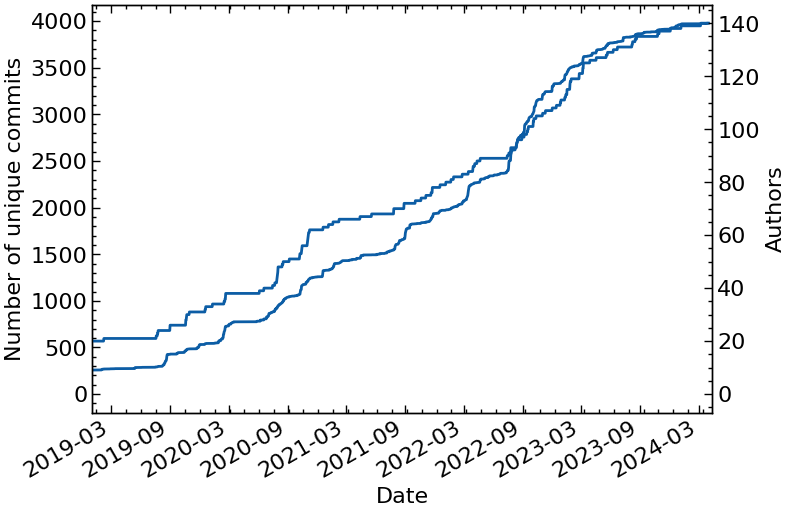

In [26]:
fig, ax = plt.subplots()
ax.plot(dates, cumm)
ax2 = ax.twinx()
ax2.plot(dates_authors, cumm_authors, label="Authors")
ax2.set_ylabel("Authors")
ax.set_xlabel("Date")
ax.set_ylabel("Number of unique commits")
ax.set_xlim(date_parser.parse("01/01/2019"), datetime.datetime.now())
import matplotlib.dates as mdates

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
fig.autofmt_xdate()

In [19]:
data_dir = Path(".").resolve().parent / "data"
assert data_dir.is_dir()
pd.Series(cumm, index=dates).to_csv(data_dir / "total_commits.csv")
pd.Series(cumm_authors, index=dates_authors).to_csv(
    data_dir / "total_commit_authors.csv"
)

In [20]:
label_mapping = {
    "ml": "Machine learning",
    "cpluspluscourse": "C++",
    "cmake": "CMake",
    "cicd github": "CI/CD w/ github",
}

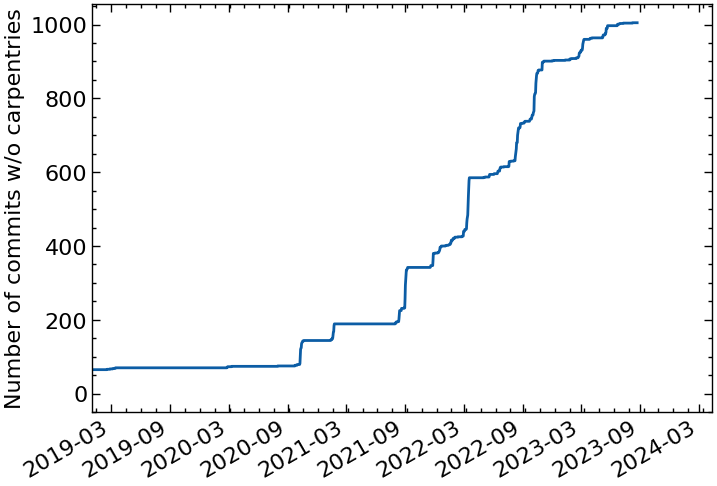

In [21]:
fig, ax = plt.subplots()
start_date = date_parser.parse("01/01/2019")
for r, vs in cc.timestamps_by_repo.items():
    # [d for d in vs if d > start_date.date()]
    label = ""
    alpha = 0.3
    ls = "-."
    dates, cumm = dates2series(vs)
    if len(vs) >= 90:
        l = r.replace("hsf-training-", "").replace("-webpage", "").replace("-", " ")
        label = label_mapping.get(l, l)
        alpha = 1
        label += rf" ($\Sigma$={max(cumm):,})"
        ls = "-"
    if not "C++" in label:
        continue
    ax.plot(dates, cumm, label=label, alpha=alpha, ls=ls)
ax.set_xlim(start_date, datetime.datetime.now())
# ax.legend()
ax.set_ylabel("Number of commits w/o carpentries")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
fig.autofmt_xdate()

In [25]:
# import numpy as np
#
# fig, ax = plt.subplots()
# start_date = date_parser.parse("01/01/2019")
# baseline = None
# for key, value in cc.timestamps_by_repo.items():
#     if baseline is None:
#         baseline = np.zeros_like(value)
#     dates, cumm = dates2series(vs)
#     label = None
#     ax.stairs(cumm+baseline, [*dates, datetime.datetime.now()], baseline=baseline, label=label, fill=True)
#     baseline = value
# ax.set_xlim(start_date, datetime.datetime.now())
# ax.legend()
# ax.set_ylabel("Number of commits w/o carpentries")
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# fig.autofmt_xdate()